In [1]:
import numpy as np 
import pandas as pd
from tensorflow import keras 
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from tqdm import tqdm
import glob
import os
import pydicom
from skimage.transform import resize
from matplotlib import pyplot as plt
import pickle

In [2]:
def encode_categorical(df):
    df['male'] = df.Sex.apply(lambda x: 1 if x == 'Male' else 0)
    df['female'] = df.Sex.apply(lambda x: 1 if x == 'Female' else 0)
    df['current_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Currently smokes' else 0)
    df['ex_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Ex-smoker' else 0)
    df['never_smoker'] = df.SmokingStatus.apply(lambda x: 1 if x == 'Never smoked' else 0)
    df.drop(['SmokingStatus','Sex'],1,inplace=True)

    return df


def extract_img_id(x):
    string = x.replace('\\','/')
    string = string.split('/')[-1]
    string = string.split('.')[0]
    return int(string)

def normalize_img(x, x_min, x_max):
    return ((x-x_min)/((x_max-x_min))).astype(np.float32)

def filter_by_std(x, alpha=0.01):
    # Remove top 1% pixel intensity
    q_pixel_max = np.quantile(x, 0.99, interpolation='linear')
    x = np.clip(x, 0, q_pixel_max)

    # Remove background just where std is below min
    mu_mat = np.mean(x, axis=0)
    std_mat = np.std(x, axis=0)
    q_std_min = np.quantile(std_mat, 0.10, interpolation='linear')

    x[:,std_mat<q_std_min] = (x-mu_mat)[:,std_mat<q_std_min]

    # ---
    x = (x-x.min())/(x.max()-x.min())
    q_std_minmin = np.quantile(x, 0.1, interpolation='linear')
    x = np.clip(x, q_std_minmin, 1.0)

    # Renormalize
    x = (x-x.min())/(x.max()-x.min())
    return x

from tensorflow.keras.applications.vgg19 import preprocess_input

def load_ct_scans(path_imgs, patient_ids, n_frames=30, frames_size=(224,224)):

    if not path_imgs.endswith('/'):
        path_imgs +='/'

    data = dict()

    # Load image
    problem_ct = []

    for patient in tqdm(patient_ids):

        image_files = glob.glob(os.path.join(path_imgs+patient,'*.dcm'))
        image_order = np.argsort(np.array([extract_img_id(x) for x in image_files]))

        imgs_list = []

        for i in image_order:
            image_data = pydicom.read_file(image_files[i])
            patient_id = image_data.PatientID
            if patient_id != patient:
                raise Exception('Patient Ids do not match')  
            
            try:
                img = np.array(image_data.pixel_array)
            except:
                problem_ct.append(patient)

            
            # Removing empty space around the CT
            mask_rows = np.argwhere(np.sum(img, axis=1) != 0).squeeze()
            mask_cols = np.argwhere(np.sum(img, axis=0) != 0).squeeze()
            img = img[mask_rows,:][:,mask_cols]
            if img.shape[0] == 0 or img.shape[1] == 0:
                continue
            imgs_list.append(img)
            
        if len(imgs_list) == 0:
            continue

        # Subsampling to 30 frames
        if len(imgs_list) > n_frames:
            subsample = np.linspace(0, len(imgs_list)-1, num=n_frames, dtype=np.int32).tolist()
            imgs_list = [imgs_list[i] for i in subsample]

        # Making all images same dimensions
        imgs_list = [resize(x, frames_size, anti_aliasing=True) for x in imgs_list]

        # Normalizing frames
        min_val = int(1e6)
        max_val = int(-1e6)
        for img in imgs_list:
            min_x = np.min(img)
            max_x = np.max(img)
            if min_x < min_val:
                min_val = min_x
            if max_x > max_val:
                max_val = max_x

        imgs_list = [normalize_img(x, min_val, max_val) for x in imgs_list]
        
        # Fill up in case there are less than 30 frames        
        if len(imgs_list) < n_frames:
            n_diff = n_frames - len(imgs_list)
            black_frame = np.zeros((frames_size[0], frames_size[1]), dtype=np.float32)
            for _ in range(n_diff):
                imgs_list.insert(0, black_frame)

        frames_scan = np.stack(imgs_list,0)
        if np.min(frames_scan) != 0 or np.max(frames_scan) != 1:
            raise Exception('Error normalization patient '+str(patient_encoder.transform([patient]))) 

        # Repeat to 3 channels for vgg
        frames_scan = np.expand_dims(frames_scan, -1)

        #Store data
        data[patient] = frames_scan.astype(np.float32)

    # Filter to remove background
    for k,v in data.items():
        ## Preprocess to get into VGG preprocessing
        data[k] = filter_by_std(v, alpha=0.01)

    return data, np.unique(problem_ct)

In [3]:
train_df = pd.read_csv('/media/i8i9/34C4AB0DC4AAD102/Users/Javi/Desktop/osic_competition/data/train.csv')
comp_df = pd.read_csv('/media/i8i9/34C4AB0DC4AAD102/Users/Javi/Desktop/osic_competition/data/test.csv')

In [4]:
CT_scans, problem_ct = load_ct_scans('/media/i8i9/34C4AB0DC4AAD102/Users/Javi/Desktop/osic_competition/data/train', np.unique(train_df.Patient))
#CT_scans_comp = load_ct_scans('/media/i8i9/34C4AB0DC4AAD102/Users/Javi/Desktop/osic_competition/data/test', np.unique(comp_df.Patient))

100%|██████████| 176/176 [02:27<00:00,  1.19it/s]


In [5]:
mask_patients = [not(x in list(comp_df['Patient'].values)) for x in list(train_df['Patient'].values)]
train_df = pd.DataFrame(train_df.values[mask_patients], columns=train_df.columns)
mask_patients = [not(x in problem_ct) for x in list(train_df['Patient'].values)]
train_df = pd.DataFrame(train_df.values[mask_patients], columns=train_df.columns)

patient_2_remove = []

for patient in list(train_df['Patient'].values):
    if patient in list(comp_df['Patient'].values) or patient in problem_ct:
        patient_2_remove.append(patient)
        
print('Train patients in test', np.unique(patient_2_remove).shape[0])

patient_encoder = LabelEncoder()
patient_label = patient_encoder.fit_transform(list(train_df['Patient'].values))

train_df = encode_categorical(train_df)
comp_df = encode_categorical(comp_df)

X = train_df.drop(['Patient'], 1)
cols_X = X.columns
X = X.values.astype(np.float32)
Y = train_df['FVC'].values.astype(np.float32)

Train patients in test 0


In [6]:
print('Tabular features on the model', cols_X)

Tabular features on the model Index(['Weeks', 'FVC', 'Percent', 'Age', 'male', 'female', 'current_smoker',
       'ex_smoker', 'never_smoker'],
      dtype='object')


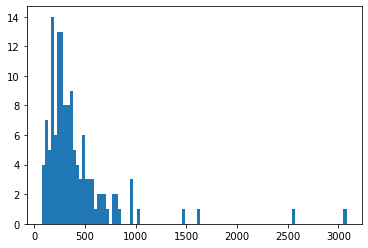

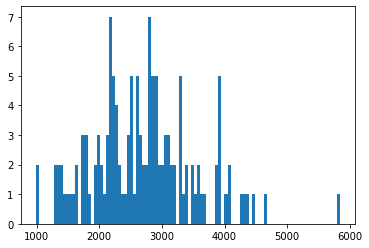

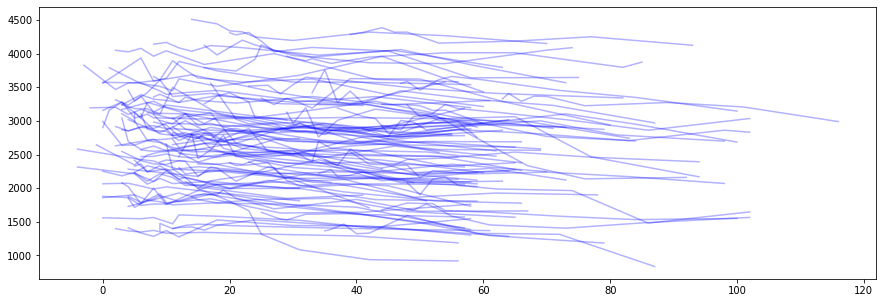

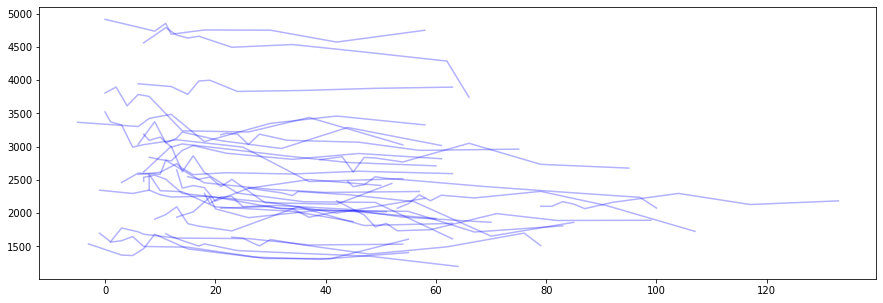

In [7]:
from sklearn.model_selection import train_test_split, GroupShuffleSplit

train_ids, test_ids = next(GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=195).split(X, groups=patient_label))
X_train, Y_train = X[train_ids], Y[train_ids]
X_test, Y_test = X[test_ids], Y[test_ids]

# Filtering out high acceleration patients -> not reliable ; remove above 900

acc_vals = []
for p in np.unique(patient_label[train_ids]):
    mask = patient_label[train_ids] == p
    vals = Y_train[mask]
    acc_vals.append(np.max(np.abs(np.diff(np.diff(vals)))))

plt.hist(acc_vals, bins=100)
plt.show()

# Filtering out extreme cases ; remove above 5000 and below 1000
avg_vals = []
for p in np.unique(patient_label[train_ids]):
    mask = patient_label[train_ids] == p
    vals = Y_train[mask]
    avg_vals.append(np.mean(vals))

plt.hist(avg_vals, bins=100)
plt.show()

# Filtering out increasing patients -> not reliable
increasing_p = []
for p in np.unique(patient_label[train_ids]):
    mask = patient_label[train_ids] == p
    vals = Y_train[mask]
    if vals[0] < vals[-1]:
        increasing_p.append(p)



vals_y = []
X_train_filtered = []
Y_train_filtered = []
X_test_filtered = []
Y_test_filtered = []
patients_train_filtered = []
patients_test_filtered = []

plt.figure(figsize=(15,5))
for p in np.unique(patient_label[train_ids]):
    mask = patient_label[train_ids] == p
    if p in increasing_p:
        continue
    if np.max(np.abs(np.diff(np.diff(Y_train[mask])))) > 900 or np.mean(Y_train[mask]) > 5000 or np.mean(Y_train[mask]) < 1200:
        continue
    plt.plot(X_train[mask,0], Y_train[mask], alpha=0.3, c='b')
    vals_y.append(Y_train[mask])
    patients_train_filtered.append([p]*X_train[mask,0].shape[0])
    X_train_filtered.append(X_train[mask])
    Y_train_filtered.append(Y_train[mask])
plt.show()

plt.figure(figsize=(15,5))
for p in np.unique(patient_label[test_ids]):
    mask = patient_label[test_ids] == p
    if p in increasing_p:
        continue
    if np.max(np.abs(np.diff(np.diff(Y_test[mask])))) > 900 or np.mean(Y_test[mask]) > 5000 or np.mean(Y_test[mask]) < 1200:
        continue
    plt.plot(X_test[mask,0], Y_test[mask], alpha=0.3, c='b')
    vals_y.append(Y_test[mask])
    patients_test_filtered.append([p]*X_test[mask,0].shape[0])
    X_test_filtered.append(X_test[mask])
    Y_test_filtered.append(Y_test[mask])
plt.show()

X_train, X_test = np.concatenate(X_train_filtered,0), np.concatenate(X_test_filtered,0)
Y_train, Y_test = np.concatenate(Y_train_filtered,0), np.concatenate(Y_test_filtered,0)
patients_train = np.concatenate(patients_train_filtered)
patients_test = np.concatenate(patients_test_filtered)

In [8]:
t = np.arange(-12,134, 1)

train_ids, val_ids = next(GroupShuffleSplit(n_splits=2, test_size=0.2, random_state=195).split(X_train, groups=patients_train))
X_val, Y_val = X_train[val_ids], Y_train[val_ids]
X_train, Y_train = X_train[train_ids], Y_train[train_ids]
patients_train, patients_val = patients_train[train_ids], patients_train[val_ids]


pacts_train = []
Xts_train = []
Yts_train = []
CTs_train = []
for p in tqdm(np.unique(patients_train)):
    mask = patients_train == p
    Y_inter = np.stack([np.interp(t, X_train[mask,0], Y_train[mask])]*X_train[mask,0].shape[0], 0)
    Yts_train.append(Y_inter)
    Xts_train.append(X_train[mask])
    pacts_train.append([p]*X_train[mask,0].shape[0])
    ct_scan = CT_scans[patient_encoder.inverse_transform([p])[0]]
    CTs_train.append(np.stack([ct_scan]*X_train[mask,0].shape[0],0))

Xts_train = np.concatenate(Xts_train, 0)
Yts_train = np.concatenate(Yts_train, 0)
pacts_train = np.concatenate(pacts_train, 0)
CTs_train = np.concatenate(CTs_train,0)


pacts_val = []
Xts_val = []
Yts_val = []
CTs_val = []
for p in tqdm(np.unique(patients_val)):
    mask = patients_val == p
    Y_inter = np.stack([np.interp(t, X_val[mask,0], Y_val[mask])]*X_val[mask,0].shape[0], 0)
    Yts_val.append(Y_inter)
    Xts_val.append(X_val[mask])
    pacts_val.append([p]*X_val[mask,0].shape[0])
    ct_scan = CT_scans[patient_encoder.inverse_transform([p])[0]]
    CTs_val.append(np.stack([ct_scan]*X_val[mask,0].shape[0],0))

Xts_val = np.concatenate(Xts_val, 0)
Yts_val = np.concatenate(Yts_val, 0)
pacts_val = np.concatenate(pacts_val, 0)
CTs_val = np.concatenate(CTs_val,0)


pacts_test = []
Xts_test = []
Yts_test = []
CTs_test = []
for p in tqdm(np.unique(patients_test)):
    mask = patients_test == p
    Y_inter = np.stack([np.interp(t, X_test[mask,0], Y_test[mask])]*X_test[mask,0].shape[0], 0)
    Yts_test.append(Y_inter)
    Xts_test.append(X_test[mask])
    pacts_test.append([p]*X_test[mask,0].shape[0])
    ct_scan = CT_scans[patient_encoder.inverse_transform([p])[0]]
    CTs_test.append(np.stack([ct_scan]*X_test[mask,0].shape[0],0))

Xts_test = np.concatenate(Xts_test, 0)
Yts_test = np.concatenate(Yts_test, 0)
pacts_test = np.concatenate(pacts_test, 0)
CTs_test = np.concatenate(CTs_test,0)

100%|██████████| 33/33 [00:00<00:00, 129.04it/s]


In [9]:
dropout = 0.05
tau = 1.0 # Should be optimized with the loglikehood
N = X_train.shape[0]
lengthscale = 1e-2
reg = lengthscale**2 * (1 - dropout) / (2. * N * tau)

In [10]:
ipt_vgg = keras.layers.Input((224,224,1))
# Block 1
x = keras.layers.Dropout(dropout)(ipt_vgg, training=True)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block1_conv1')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block1_conv2')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block2_conv1')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block2_conv2')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block3_conv1')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block3_conv2')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block3_conv3')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block3_conv4')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block4_conv1')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block4_conv2')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block4_conv3')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block4_conv4')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block5_conv1')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block5_conv2')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block5_conv3')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=keras.regularizers.l2(reg), padding='same', name='block5_conv4')(x)
x = keras.layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

# Top
x = keras.layers.Flatten(name='flatten')(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Dense(512, activation='relu', name='fc1', kernel_regularizer=keras.regularizers.l2(reg))(x)
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Dense(512, activation='relu', name='fc2', kernel_regularizer=keras.regularizers.l2(reg))(x)

vgg_model = keras.models.Model(ipt_vgg, x, name='dropped_vgg19')

In [11]:
ipt_ct = keras.layers.Input((30,224,224,1))
x_ct = keras.layers.TimeDistributed(vgg_model, name='timed_dropped_vgg')(ipt_ct)
x_ct = keras.layers.Dropout(dropout)(x_ct, training=True)
x_ct = keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(reg))(x_ct)
x_ct = keras.layers.Flatten()(x_ct)
x_ct = keras.layers.Dropout(dropout)(x_ct, training=True)
x_ct = keras.layers.Dense(100, activation='relu', kernel_regularizer=keras.regularizers.l2(reg))(x_ct)

ipt_tab = keras.layers.Input((X.shape[1],))

x = keras.layers.Concatenate()([x_ct, ipt_tab])
x = keras.layers.Dropout(dropout)(x, training=True)
x = keras.layers.Dense(Yts_train.shape[1], activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg))(x)

model = keras.models.Model([ipt_ct, ipt_tab], x, name='dropped_end2end')
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [12]:
class CtScaler:
    def __init__(self):
        pass
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)+1e-12
    
    def transform(self, X):
        return (X-self.mean_)/self.std_

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

    def inverse_transform(self, X):
        return X*self.std_ + self.mean_

In [13]:
'''#scaler_CT = CtScaler()
scaler_X = StandardScaler()
#scaler_Y = StandardScaler()

Xts_train = scaler_X.fit_transform(Xts_train)
#Yts_train = scaler_Y.fit_transform(Yts_train)
#CTs_train = scaler_CT.fit_transform(CTs_train)

scalers_dict = {'CT': scaler_CT, 'X': scaler_X, 'Y': scaler_Y}
pickle.dump(scalers_dict, open('./checkpoints/scalers.pickle', 'wb'))'''

"#scaler_CT = CtScaler()\nscaler_X = StandardScaler()\n#scaler_Y = StandardScaler()\n\nXts_train = scaler_X.fit_transform(Xts_train)\n#Yts_train = scaler_Y.fit_transform(Yts_train)\n#CTs_train = scaler_CT.fit_transform(CTs_train)\n\nscalers_dict = {'CT': scaler_CT, 'X': scaler_X, 'Y': scaler_Y}\npickle.dump(scalers_dict, open('./checkpoints/scalers.pickle', 'wb'))"

In [14]:
scaler_X = StandardScaler()
scaler_Y = MinMaxScaler()
Xts_train = scaler_X.fit_transform(Xts_train)
Yts_train = scaler_Y.fit_transform(Yts_train)

In [15]:
Xts_val = scaler_X.transform(Xts_val)
Yts_val = scaler_Y.transform(Yts_val)
#CTs_val = scaler_CT.transform(CTs_val)

In [16]:
scalers = { 'X': scaler_X, 'Y': scaler_Y}
pickle.dump(scalers, open('./checkpoints/scalers.pickle', 'wb'))

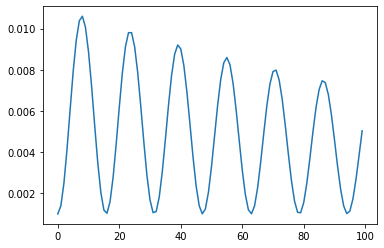

In [17]:
R = np.arange(0,100)
plt.plot(0.001+0.01*np.sin(R/5)**2*np.exp(-R/200))
plt.show()

In [18]:
# For continuing with the training
def scheduler(epoch, lr):
    lr_0 = 0.0005
    return lr_0+0.01*np.sin(epoch/5)**2*np.exp(-epoch/200)

model = keras.models.load_model('./checkpoints/end2end_dropout_tau_1.0.053-0.003.h5')
callbacks = [keras.callbacks.LearningRateScheduler(scheduler, verbose=1)]

In [19]:
'''callbacks.append(keras.callbacks.ModelCheckpoint('./checkpoints/end2end_dropout_tau_'+str(tau)+'.{epoch:03d}-{val_loss:.4f}.h5',
                                              monitor='val_loss',
                                              verbose=0,
                                              save_best_only=True))

model.fit([CTs_train,Xts_train], Yts_train, validation_data=([CTs_val,Xts_val], Yts_val), initial_epoch=53, epochs=100, verbose=1, batch_size=16, callbacks=callbacks)'''

"callbacks.append(keras.callbacks.ModelCheckpoint('./checkpoints/end2end_dropout_tau_'+str(tau)+'.{epoch:03d}-{val_loss:.4f}.h5',\n                                              monitor='val_loss',\n                                              verbose=0,\n                                              save_best_only=True))\n\nmodel.fit([CTs_train,Xts_train], Yts_train, validation_data=([CTs_val,Xts_val], Yts_val), initial_epoch=53, epochs=100, verbose=1, batch_size=16, callbacks=callbacks)"

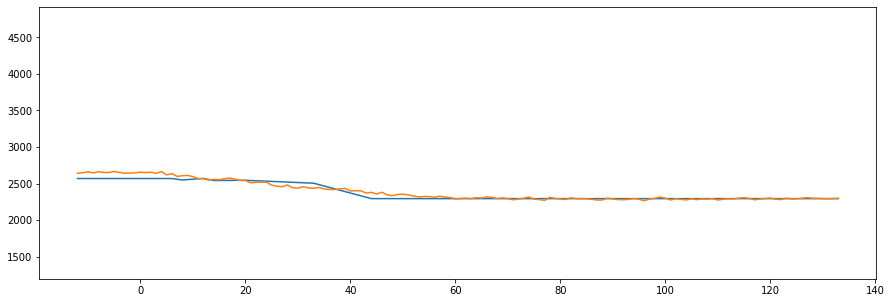

In [20]:
i = np.random.randint(Xts_val.shape[0])
x = Xts_val[i:i+1]
y = Yts_val[i:i+1]
ct = CTs_val[i:i+1]

y_pred = scaler_Y.inverse_transform(model.predict([ct,x]))

plt.figure(figsize=(15,5))
plt.plot(t, scaler_Y.inverse_transform(y).flatten())
plt.plot(t, y_pred.flatten())
plt.ylim(np.min(Yts_test), np.max(Yts_test))
plt.show()

In [25]:
i = np.random.randint(Xts_val.shape[0])
x = Xts_val[i:i+1]
y = Yts_val[i:i+1]
ct = CTs_val[i:i+1]

y_preds = []
for i in tqdm(range(100)):
    y_preds.append(scaler_Y.inverse_transform(model.predict([ct,x])).flatten())

y_preds = np.stack(y_preds,1)

100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


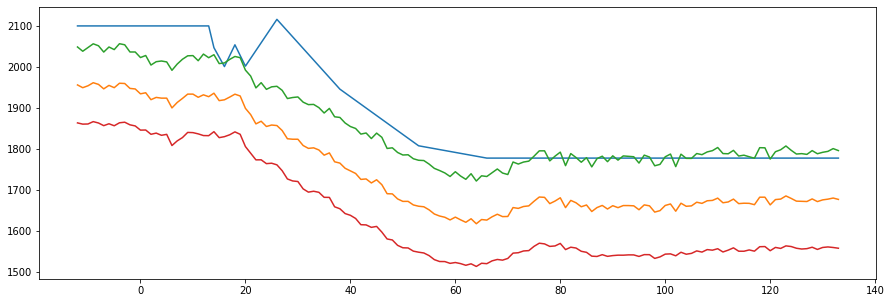

In [27]:
plt.figure(figsize=(15,5))
plt.plot(t, scaler_Y.inverse_transform(y).flatten(), c='g', linestyle='--')
plt.scatter(t, x[0], c='g', linestyle='--')
plt.plot(t, np.mean(y_preds, 1), )
plt.plot(t, np.mean(y_preds, 1)+np.std(y_preds, 1))
plt.plot(t, np.mean(y_preds, 1)-np.std(y_preds, 1))
plt.show()

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(t, scaler_Y.inverse_transform(y).flatten())
plt.plot(t, y_pred.flatten())
plt.show()

In [ ]:
i = np.random.randint(Xts_val.shape[0])
x = Xts_val[i:i+1]
y = Yts_val[i:i+1]
ct = CTs_val[i:i+1]

N_pred = 1000

y_pred = []
for _ in tqdm(range(N_pred)):
    y_pred.append(scaler_Y.inverse_transform(model.predict([ct,x])).flatten())
y_pred = np.stack(y_pred, 1)

In [ ]:
def process_prediction(Y, ci=0.95):
    Y_mean = np.mean(Y, 0)

    Y_cis = []
    for i in range(Y.shape[1]):
        counts, bins = np.histogram(Y[:,i], bins=300)
        cdf = np.cumsum(counts/counts.sum())
        bins_center = np.array([round((bins[i+1]+bins[i])/2,6) for i in range(bins.shape[0]-1)])
        id_bin_mean = np.argmin(np.abs(bins_center - Y_mean[i]))
        prob_mean = cdf[id_bin_mean]

        id_ci_low = np.argmin(np.abs((cdf-prob_mean)-(-ci/2)))
        ci_low = bins_center[id_ci_low]

        id_ci_up = np.argmin(np.abs((cdf-prob_mean)-(ci/2)))
        ci_up = bins_center[id_ci_up]

        if np.abs(Y_mean[i]-ci_up) >= np.abs(Y_mean[i]-ci_low):
            Y_cis.append(np.abs(Y_mean[i]-ci_up))
        else:
            Y_cis.append(np.abs(Y_mean[i]-ci_low))

    return np.stack([Y_mean, np.array(Y_cis)], 1)

In [ ]:
i = 10

N_pred = 100

Xpatient = np.repeat(Xts_test[i].reshape(1,-1), N_pred, 0)
CTpatient = np.repeat(np.expand_dims(CTs_test[i], 0), N_pred, 0)

Y = scalers['Y'].inverse_transform(model.predict([CTpatient, Xpatient]))
predictions = process_prediction(Y, ci=0.95)


plt.figure(figsize=(15,5))
plt.plot(t, Yts_test[i])
plt.plot(t, predictions[:,0])
plt.plot(t, predictions[:,0]+predictions[:,1])
plt.plot(t, predictions[:,0]-predictions[:,1])
plt.show()